In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [6]:
### Data Cleaning 
tcga = pd.read_excel('./data/TCGA_GBM_exp_HiSeqV2-2015-02-24.xlsx')
tcga = tcga.transpose().reset_index()
tcga.columns = tcga.iloc[0]
cols = list(tcga.columns)
cols[0] = 'patient_id'
tcga.columns = cols
tcga_gal = tcga[['patient_id', 'LGALS1', 'MGMT', 'CDKN1A', 'DNMT1']]
tcga_gal = tcga_gal.iloc[:, [0, 3, 5, 7, 9]]

clinical = pd.read_excel('./data/GBM clinical_data.xls')
keep = [
    'sampleID', 
    'CDE_DxAge', 
    'CDE_tmz_chemoradiation_standard', 
    'CDE_chemo_tmz',
    'CDE_radiation_standard', 
    '_OS', 
    '_OS_IND'
]

clinical = clinical[keep]

final = clinical.merge(tcga_gal, how='inner', right_on='patient_id', left_on='sampleID')
to_nums = ['LGALS1', 'MGMT', 'CDKN1A', 'DNMT1']
for col in to_nums:
    final[col] = pd.to_numeric(final[col])
final.to_csv('./data/clean.csv')

In [8]:
df = pd.read_csv('./data/clean.csv')
df = df[~df['_OS_IND'].isnull()].reset_index(drop = True)

df = df.rename(
    columns=
        {
            'CDE_radiation_standard' : 'radiation',
            'CDE_chemo_tmz' : 'tmz'
        }
)


df['Survival Time (months)'] = df['_OS'] / 12
df['Event'] = df['_OS_IND'].apply(lambda x: 'Died' if x > 0 else 'Survived')
df['Event'] = pd.Categorical(df['Event'], ['Survived', 'Died'])

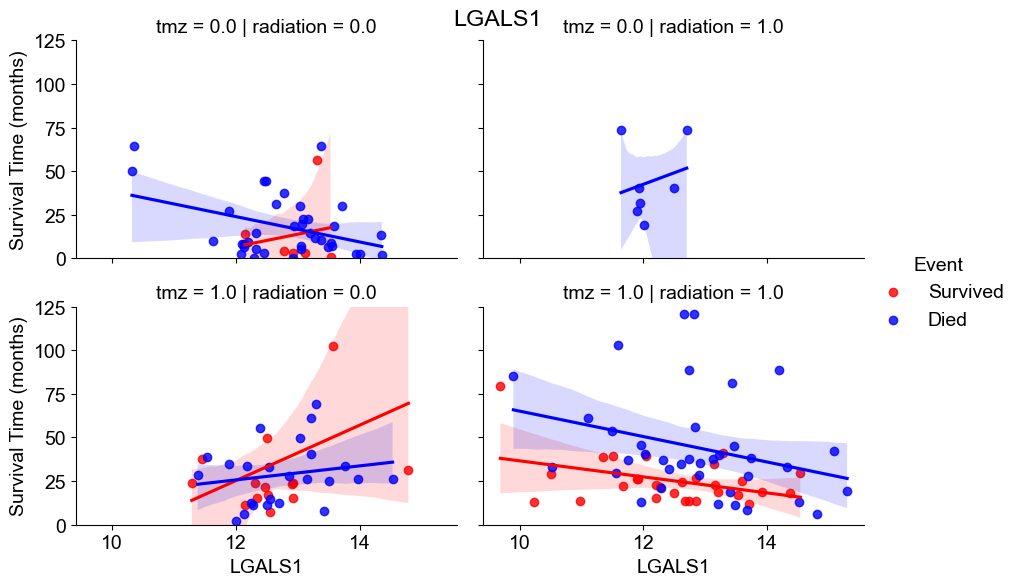

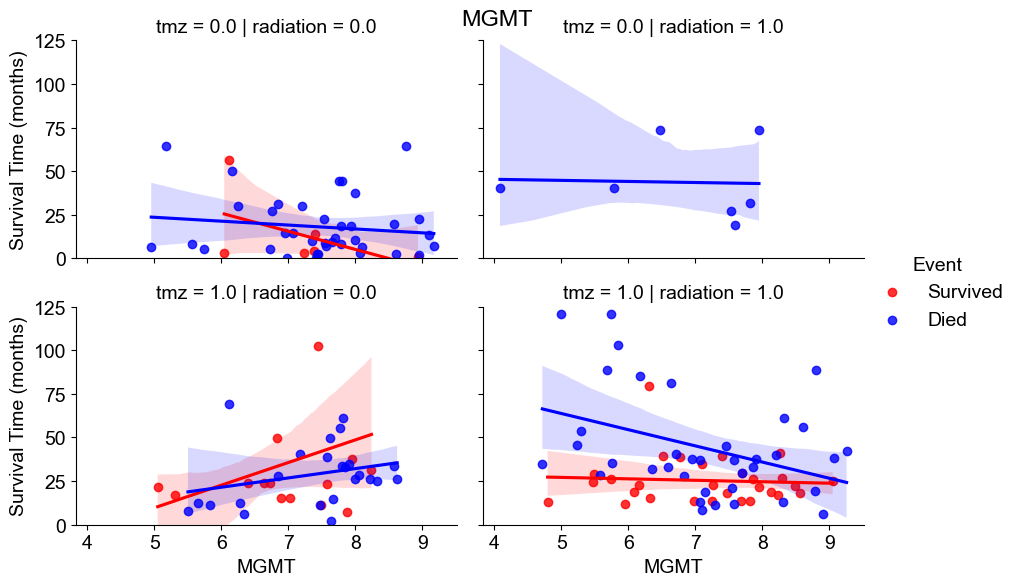

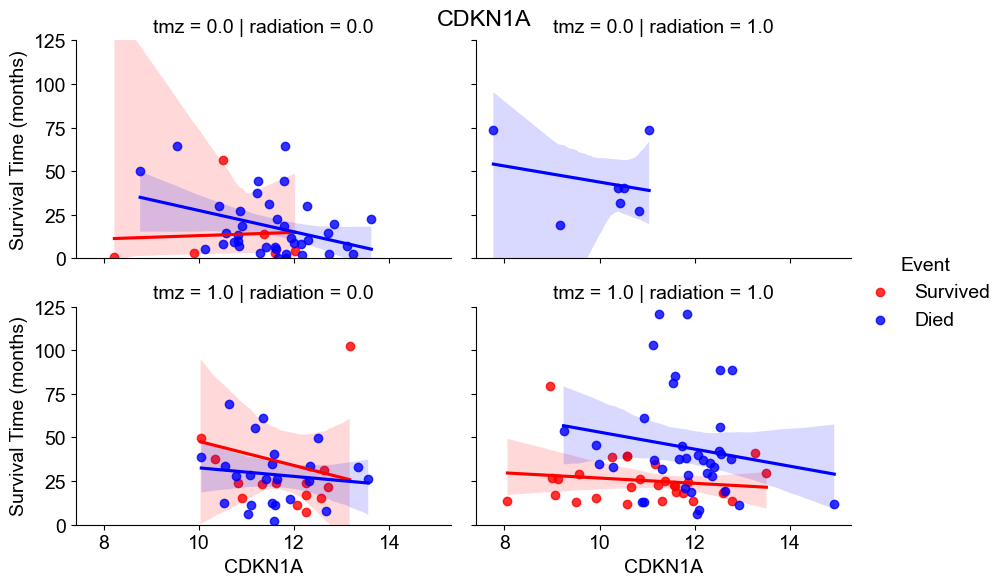

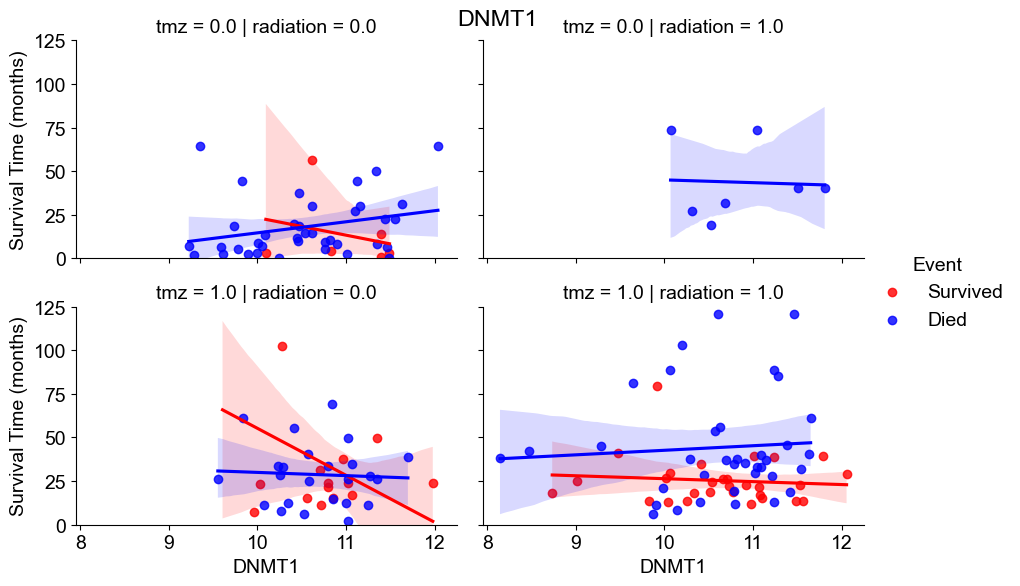

In [10]:
### Scatterplots
genes = ['LGALS1', 'MGMT', 'CDKN1A', 'DNMT1']
with plt.style.context('default'), plt.rc_context({'font.size' : 14, 'font.family' : 'Arial'}):
    for gene in genes:    
            sns.lmplot(df, x = gene, y = 'Survival Time (months)', col = 'radiation', row = 'tmz', hue = 'Event',
            height=3, aspect=1.5, palette=['red', 'blue']).fig.suptitle(gene)
            plt.ylim(0, 125)
            plt.savefig(f'./imgs/{gene}.png')
            plt.show()

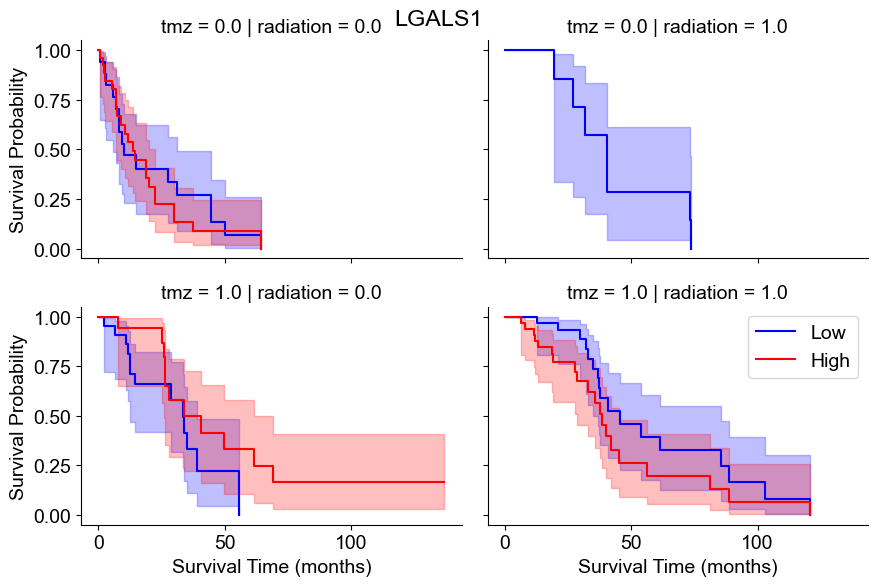

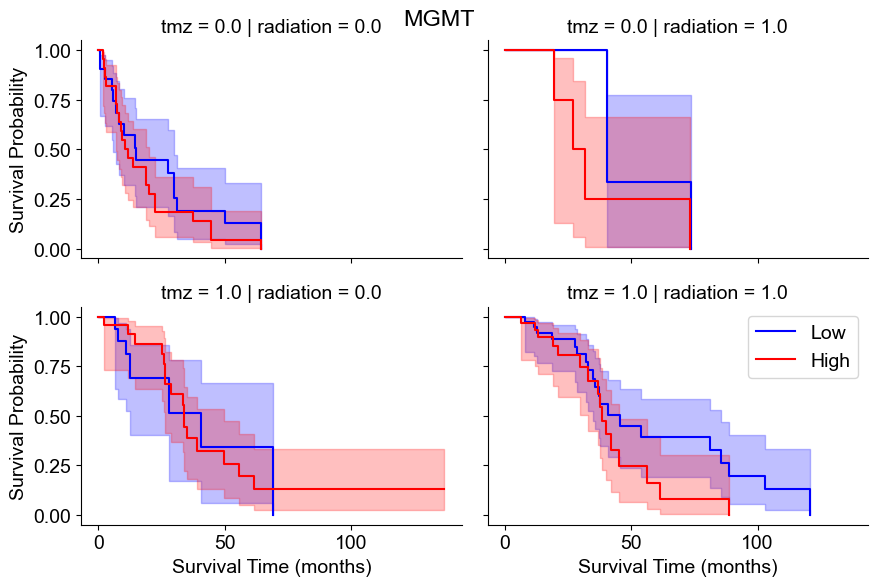

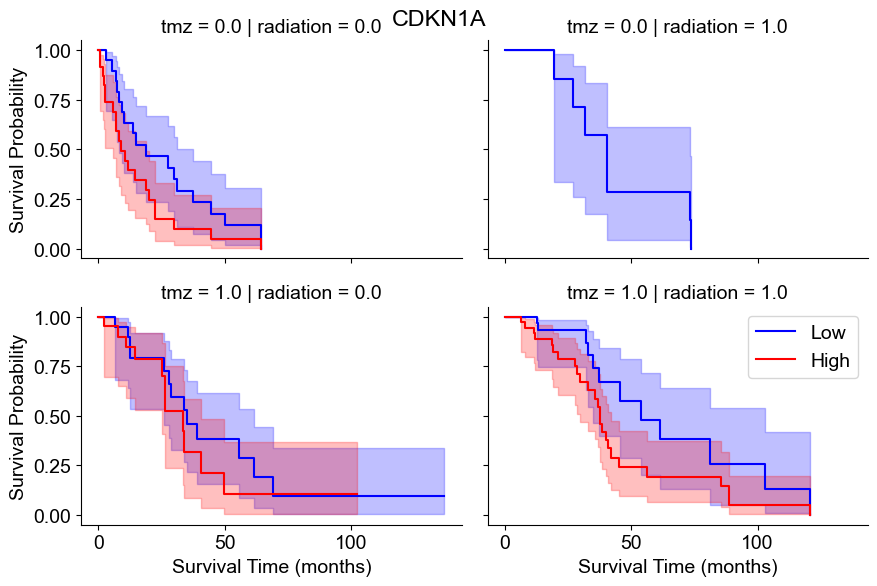

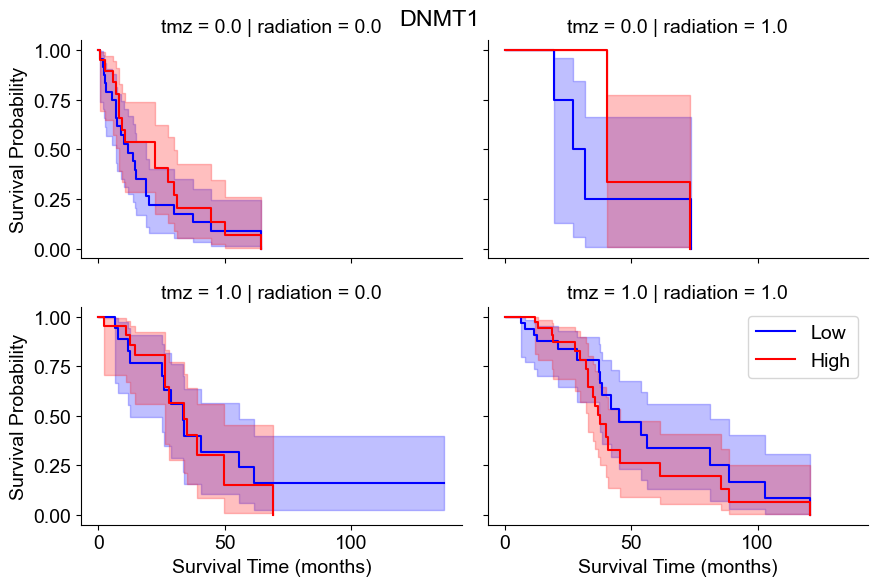

In [11]:
### Kaplan-Meier Plots
df = df.rename(columns={'_OS_IND' : 'event'})
genes = ['LGALS1', 'MGMT', 'CDKN1A', 'DNMT1']

# define a custom plotting function
def custom_plot(x, y, **kwargs):
    ge = kwargs['gene_expression']
    split = ge.median()
    mask = ge <= split

    kmf = KaplanMeierFitter()
    kmf.fit(x[mask], y[mask])
    kmf.plot(label = 'Low', color = 'blue')

    if not x[~mask].empty:

        kmf.fit(x[~mask], y[~mask])
        kmf.plot(label = 'High', color = 'red')

with plt.style.context('default'), plt.rc_context({'font.size' : 14, 'font.family' : 'Arial'}):    
    for gene in genes:    
            # create a facetgrid object
            g = sns.FacetGrid(df, col="radiation", row="tmz", height = 3, aspect = 1.5)
                
            # use the custom plot function
            g = g.map(custom_plot, "Survival Time (months)", "event", gene_expression = df[gene])

            g.fig.suptitle(gene)
            g.set_ylabels('Survival Probability')
            plt.legend()
            plt.savefig(f'./imgs/{gene}_KM.png')
            plt.show()